# Preprocessing and Feature Engineering

In this notebook I will create a clean dataset ready to model through feature engineering and standardization.

First load the data from EDA, and clean up any extraneous columns that will not be used in prediction.  Then I will split the data into predictors and target.

Next I will perform PCA to see the principal components of the data.  The principal components may be used as input to the modelling phase. 

Finally I will perform a train-test split and apply a basic logistic regression model to the data. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import traceback

In [2]:
random_seed = 27

In [3]:
train = pd.read_csv('train_w_aggregated_weather.csv',index_col=0)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4616 entries, 0 to 4615
Columns: 110 entries, Date to Daylight
dtypes: float64(82), int64(22), object(6)
memory usage: 3.9+ MB


In [4]:
print('Length of data:',train.shape[0])
print('Duplicate Traps & dates:',train.duplicated(subset=['Date','Trap']).sum())

Length of data: 4616
Duplicate Traps & dates: 0


Looks good. I will clean up (drop) some columns that can't be used or will not be available for prediction.  

In [5]:
### drop mosquito species columns, won't have that for predicting 
train = train.drop(['RESTUANS','PIPIENS','SALINARIUS','TERRITANS',\
                    'TARSALIS','ERRATICUS'],axis=1)

In [6]:
### Drop extraneous columns that won't be used in modeling
train = train.drop(['Date','Trap','Address','Block','Street',\
                    'AddressNumberAndStreet','Latitude','Longitude',\
                   'AddressAccuracy','Station'],axis=1)

In [7]:
### Drop CodeSum string columns
#train = train.drop(['CodeSum_3days','CodeSum_7days','CodeSum_14days']\
                   #,axis=1)
train = train.drop('CodeSum',axis=1)

In [8]:
### Finally drop the number of mosquitos column and Yearly columns
### as this will not be available for prediction
train = train.drop('NumMosquitos',axis=1)
train = train.drop(['Year','WnvPerc_yearly'],axis=1)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4616 entries, 0 to 4615
Data columns (total 90 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   WnvPresent         4616 non-null   float64
 1   Month              4616 non-null   int64  
 2   Week               4616 non-null   int64  
 3   WnvPerc_monthly    4616 non-null   float64
 4   WnvPerc_weekly     4616 non-null   float64
 5   Station_dist       4616 non-null   float64
 6   Tmax               4616 non-null   int64  
 7   Tmin               4616 non-null   int64  
 8   Tavg               4616 non-null   int64  
 9   Depart             4616 non-null   float64
 10  DewPoint           4616 non-null   int64  
 11  WetBulb            4616 non-null   int64  
 12  Heat               4616 non-null   int64  
 13  Cool               4616 non-null   int64  
 14  PrecipTotal        4616 non-null   float64
 15  StnPressure        4616 non-null   float64
 16  SeaLevel           4616 

Looks great the data set is all numeric and there are no nulls to be found.  Now I will split the train and test data.

In [10]:
### Split into X and y
y = train['WnvPresent']
X = train.drop('WnvPresent',axis=1)

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,\
                                 test_size=.2,random_state=random_seed)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(type(X_train))

(3692, 89)
(924, 89)
(3692,)
(924,)
<class 'pandas.core.frame.DataFrame'>


In [12]:
print('Testing Fraction positive:  {:.3f} '.format(y_test.sum()/y_test.shape[0]))
print('Training Fraction positive: {:.3f}'.format(y_train.sum()/y_train.shape[0]))

Testing Fraction positive:  0.083 
Training Fraction positive: 0.083


That data are now split into testing and training set, and each now has the same proportion of positive cases. 

Now I will implement Rahul's function for calculating the predictive power of each feature.  The function calculates weight of evidence and Information value for each feature.  The features with little information value or suspiciously high information value will be dropped.    
___
After that I will check the colinearity of the features in the training data set and drop any features that are highly correlative to others. (Helping to reduce model overfitting to the training set).    

In [13]:
### Function to calculate the Information Value (IV) of each feature
### 


max_bin = 20
force_bin = 3
import pandas.core.algorithms as algos
import scipy.stats.stats as stats


# define a binning function
### this function is for binning and calculating the Weight of Evidence 
### for the target and the Information Value for the feature
### and the In
def mono_bin(Y, X, n = max_bin):    
    ### create new dataframe of series feature and series y
    df1 = pd.DataFrame({"X": X, "Y": Y})
    
    ### check to see if any nulls in feature and seperate nulls out
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    #print("justmiss", justmiss)
    #print("notmiss", notmiss)
    
    
    ### while loop until Spearman correlation coefficient is between [-1,1]
    ### Finding minumum bin size that results in 'abs(r)' of >1???
    
    r = 0
    while np.abs(r) < 1:
        ### Try creation of new dataframe with max or less bin size 'n'
        ### create dataframe with feature, target and binned feature 
        ### create 'd2' group by object on 'Bucket'
        ### calculate Spearman correlation 'r' and p-value from mean of feature and target
        ### If exception reduce bin number by one and try again
        ### Effectively finding the max bin number that can be used 
        ### for calculating WOE
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y,\
                               "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
                             
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            #print("I am here 1",r, n,len(d2))
            n = n - 1 
            
            
        except Exception as e:
            n = n - 1
            #print("I am here e",n)

    ### If length of d2 is 1 (ie 1 bucket for all of feature) do this
    if len(d2) == 1:
        #print("I am second step ",r, n)
        
        ### force 'n' to 3 and calculate quantiles of feature from (0,0.5,1) 
        ### to be used as bins, if not 3 unique because of heavily skewed data
        ### manually create bin
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
            
        ### Create new dataframe bucketed by manual bins
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    ### Create new dataframe from aggregating the binned dataframe
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        #print(justmiss.count().Y)
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    ### add more features to d3 describing the 'events' of the target
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    print(np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT))
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    #print("hi",d3.IV )
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    import traceback
    
    
    ### Extract raw traceback from error in one of the two sub functions
    ### assign traceback elemnts to variables
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    
    ###
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    
    ### get column names from df1
    x = df1.dtypes.index
    
    count = -1
    ### Loop through columns
    for i in x:
        print(i)
        if i.upper() not in (final.upper()):
            ### test if numeric and not a one-hot encoding
            if np.issubdtype(df1[i], np.number) and len(pd.Series.unique(df1[i])) > 2:
                #print("Number and unique value greater than 2")
                ###  pass target and feature to 'mono_bin'
                conv = mono_bin(target, df1[i])
                
                ### assign feature name to 'conv'
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                #print("I am here 2")
                ###  pass target and feature to 'char_bin'
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1

            ### First time run through the loop where count==0,
            ### create new df from current
            if count == 0:
                iv_df = conv
            ### on subsequent loops append rows to bottom of 'iv_df'
            ### of next feature and scoring calcs
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    ### aggregate 'iv_df' taking the maximum ?correlation? score 
    ### for each feature and creating a new summary df with columns 
    ### 'VAR_NAME' & 'IV'
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    ### return detailed df with all computed features
    ### and summary of only max values and feature names
    return(iv_df,iv)

In [14]:
iv_df, iv = data_vars(X_train,y_train)

Month
0    0.023442
1   -0.063943
dtype: float64
Week
0   -0.695860
1    0.525263
dtype: float64
WnvPerc_monthly
0   -1.623266
1    0.041682
2    0.902687
dtype: float64
WnvPerc_weekly
0        -inf
1   -1.541127
2   -0.625741
3    0.090856
4    0.771610
5    1.150368
dtype: float64
Station_dist
0    0.187484
1    0.148937
2   -0.128418
3   -0.279187
dtype: float64
Tmax

C:\Users\blain\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



0   -0.171726
1    0.077307
2    0.078511
dtype: float64
Tmin
0   -0.434256
1    0.330288
dtype: float64
Tavg
0   -0.140065
1    0.141578
dtype: float64
Depart
0   -0.194097
1    0.191029
dtype: float64
DewPoint
0   -0.489503
1   -0.240641
2    0.536245
dtype: float64
WetBulb
0   -0.925829
1   -0.217185
2    0.045339
3    0.217189
4    0.314616
5    0.436380
dtype: float64
Heat
0    0.117716
1   -1.318889
dtype: float64
Cool
0   -0.140065
1    0.141578
dtype: float64
PrecipTotal
0    0.004536
1   -0.242343
dtype: float64
StnPressure
0    0.037385
1   -0.039403
dtype: float64
SeaLevel
0   -0.038266
1    0.039788
dtype: float64
AvgSpeed
0    0.263406
1    0.019128
2   -0.366412
dtype: float64
WindDirection
0    -0.796378
1     0.493363
2     0.011293
3    -0.247094
4     0.199489
5    -0.679061
6    -0.684176
7     0.483594
8    -0.747438
9     0.924477
10    0.121780
11    0.212393
12         NaN
13    0.401042
14   -0.886700
15   -0.744972
16    0.052886
dtype: float64
WindSpeed
0    

C:\Users\blain\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



PrecipTotal_lag6
0   -0.183224
1    0.256242
dtype: float64
PrecipTotal_lag7
0    0.012020
1   -0.795133
dtype: float64
PrecipTotal_lag8
0   -0.006639
1    0.250133
dtype: float64
PrecipTotal_lag9
0   -0.008952
1    0.787276
dtype: float64
PrecipTotal_lag10
0    0.020642
1   -0.518049
dtype: float64
PrecipTotal_lag11
0    0.000296
1        -inf
dtype: float64
PrecipTotal_lag12
0   -0.002690
1    0.123116
dtype: float64
PrecipTotal_lag13
0   -0.014816
1    0.588425
dtype: float64

C:\Users\blain\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



PrecipTotal_lag14
0   -0.037260
1    1.180319
dtype: float64
Tavg_agg3
0   -0.875981
1   -0.078759
2    0.274617
3    0.342863
dtype: float64
PrecipTotal_agg3
0    0.065453
1   -0.070556
dtype: float64
DewPoint_agg3
0   -0.810668
1   -0.701876
2   -0.433315
3    0.006641
4    0.315043
5    0.357660
6    0.688336
dtype: float64
WetBulb_agg3
0   -1.028914
1   -0.370071
2    0.366908
3    0.526286
dtype: float64
StnPressure_agg3
0    0.009229
1   -0.009630
dtype: float64
SeaLevel_agg3
0   -0.009255
1    0.009715
dtype: float64
AvgSpeed_agg3
0    0.203051
1    0.056527
2   -0.321808
dtype: float64
Tavg_agg7
0   -0.737107
1    0.177510
2    0.324935
dtype: float64
PrecipTotal_agg7
0   -0.153198
1   -0.088193
2   -0.041567
3    0.247403
dtype: float64
DewPoint_agg7
0   -0.968939
1   -0.815989
2   -0.292105
3    0.154369
4    0.353640
5    0.733639
dtype: float64
WetBulb_agg7
0   -0.794763
1   -0.708218
2    0.406148
3    0.516555
dtype: float64
StnPressure_agg7
0   -0.336964
1    0.264218
d

In [15]:
iv.sort_values('IV',ascending=False).head(20)

,VAR_NAME,IV
87,WnvPerc_monthly,0.992365
88,WnvPerc_weekly,0.727134
9,Daylight,0.540767
69,Week,0.354774
13,DewPoint_agg7,0.353727
62,Tavg_lag3,0.342719
72,WetBulb_agg7,0.336424
71,WetBulb_agg3,0.334183
73,WetBulb_lag1,0.320081
80,WindDirection,0.282884


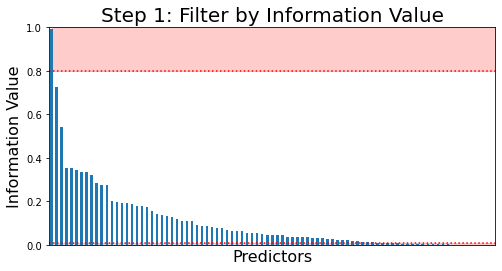

In [16]:

iv = iv.sort_values('IV',ascending=False)
iv.plot(x='VAR_NAME',y='IV',kind='bar',figsize=(8,4))
plt.xlabel('Predictors',fontsize=16)
plt.ylabel('Information Value',fontsize=16)
plt.axhline(0.01,color = 'red',linestyle=':')
plt.axhline(0.8,color = 'red',linestyle=':')

plt.fill_between(x=[0,len(iv)],y1=1,y2=0.8,color='red',alpha=0.2)
plt.fill_between(x=[0,len(iv)],y1=0,y2=0.01,color='red',alpha=0.2)
plt.ylim((0,1))


plt.xticks([])

plt.title('Step 1: Filter by Information Value',fontsize=20)

plt.legend().remove()
plt.show()

Looks good. Now to filter out features with very low (0.01) and very high (0.8) information value.

In [17]:
features = list(iv[(iv['IV'] >= 0.01) & (iv['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]

display(X2.shape)

X2.head()

(3692, 64)

,WnvPerc_weekly,Daylight,Week,DewPoint_agg7,Tavg_lag3,WetBulb_agg7,WetBulb_agg3,WetBulb_lag1,WindDirection,DewPoint_lag1,...,PrecipTotal_lag3,PrecipTotal_agg7,WindSpeed_lag1,Tavg,Cool,StnPressure_lag5,WindSpeed_lag5,Tmax,DewPoint_lag3,PrecipTotal_lag10
1916,0.055794,14.900000,29,54.000000,71.0,61.857143,62.333333,63.0,290,57.0,...,0.00,1.62,9.6,64,0,29.41,1.9,70,49.0,0.00
2613,0.004000,15.200000,26,56.142857,74.0,62.428571,63.333333,62.0,160,55.0,...,0.14,0.18,3.9,78,13,29.28,3.9,89,64.0,1.23
2022,0.095930,14.483333,31,57.000000,75.0,63.142857,60.666667,62.0,260,57.0,...,0.01,0.05,4.4,70,5,29.13,8.0,81,60.0,0.04
4368,0.194872,12.950000,36,58.428571,67.0,63.714286,61.666667,60.0,170,53.0,...,0.00,0.98,9.2,74,9,29.11,3.9,85,54.0,0.00
1530,0.000000,15.016667,23,50.000000,66.0,55.428571,53.666667,58.0,30,54.0,...,0.01,0.91,1.0,56,0,29.11,6.8,61,46.0,0.01


Excellent. I have reduced the number of features from 89  to 64.  Now I am sure some of the features are highly correlated.  I will asses the colinearity of the data and then remove any highly correlative features.

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        
        ### Create data frame with features column and 
        ### variance inflation factor column
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
            #if count==45:
                #print('early stop for plotting intermediate step')
                #return df, vif.sort_values('VIFactor')  
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')  



In [19]:
X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing WetBulb_agg7 with VIF of inf
Iteration # 2


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing WetBulb_agg3 with VIF of inf
Iteration # 3


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing DewPoint_lag1 with VIF of inf
Iteration # 4


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing Tavg_agg3 with VIF of inf
Iteration # 5


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing Heat with VIF of inf
Iteration # 6


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing StationLat with VIF of inf
Iteration # 7
Removing StationLong with VIF of 546764.251752
Iteration # 8
Removing SeaLevel_agg7 with VIF of 67443127.687892
Iteration # 9
Removing StnPressure_agg7 with VIF of 1055903.936805
Iteration # 10
Removing StnPressure_lag4 with VIF of 775396.821513
Iteration # 11
Removing Tavg_agg7 with VIF of 317996.744886
Iteration # 12
Removing StnPressure_lag3 with VIF of 176504.251355
Iteration # 13
Removing Tavg with VIF of 147239.853930
Iteration # 14
Removing DewPoint_agg7 with VIF of 108602.270291
Iteration # 15
Removing DewPoint_agg3 with VIF of 50223.844279
Iteration # 16
Removing Daylight with VIF of 43089.496604
Iteration # 17
Removing WetBulb with VIF of 28239.161275
Iteration # 18
Removing WetBulb_lag5 with VIF of 24995.307127
Iteration # 19
Removing WetBulb_lag2 with VIF of 24977.586900
Iteration # 20
Removing WetBulb_lag6 with VIF of 24130.901000
Iteration # 21
Removing WetBulb_lag7 with VIF of 20892.178396
Iteration # 22
Removing WetBulb_

In [20]:
final_vif

,VIFactor,features
11,1.193419,PrecipTotal_lag10
4,1.196037,PrecipTotal_lag6
5,1.236702,PrecipTotal_lag14
3,1.253992,PrecipTotal_lag5
7,1.293330,PrecipTotal_lag2
8,1.324362,PrecipTotal_lag3
6,1.351872,Depart
0,2.405664,WnvPerc_weekly
9,3.873481,WindSpeed_lag1
2,4.135717,WindSpeed_lag3


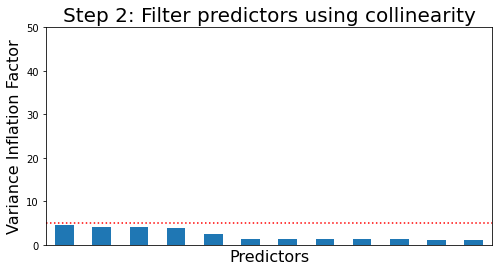

In [21]:
final_vif = final_vif.sort_values('VIFactor',ascending=False)
final_vif.plot(x='features',y='VIFactor',kind='bar',figsize=(8,4))
plt.axhline(5,color='red',linestyle=':')

plt.ylabel('Variance Inflation Factor',fontsize=16)
plt.ylim(0,50)
plt.yticks([0,10,20,30,40,50])

if final_vif.iloc[0].VIFactor > 5:
    plt.fill_betweenx(y=[0,50],x1=-2,x2=.5,color='red',alpha=.2)

plt.xlabel('Predictors',fontsize=16)
plt.xticks([])

plt.title('Step 2: Filter predictors using collinearity',fontsize=20)
plt.legend().remove()
plt.show()

In [22]:
final_vif.iloc[0].VIFactor

4.494276287586135

I am concerned how dominant PrecipTotal and WindSpeed lag columns are in the new much smaller data set.  I will continue on for now.    

In [23]:
final_df.shape

(3692, 12)

Alright. I have gone from 64 features down to 13 by dropping based on colinearity.  

In [24]:
X_train = final_df
X_test = X_test[X_train.columns]
print(X_train.shape)
print(X_test.shape)
X_cols = final_df.columns

(3692, 12)
(924, 12)


In [25]:
X_train

,WnvPerc_weekly,WindDirection,WindSpeed_lag3,PrecipTotal_lag5,PrecipTotal_lag6,PrecipTotal_lag14,Depart,PrecipTotal_lag2,PrecipTotal_lag3,WindSpeed_lag1,WindSpeed_lag5,PrecipTotal_lag10
1916,0.055794,290,7.5,0.00,1.12,0.00,-10.0,0.32,0.00,9.6,1.9,0.00
2613,0.004000,160,6.4,0.01,0.00,0.03,6.0,0.00,0.14,3.9,3.9,1.23
2022,0.095930,260,6.4,0.01,0.00,0.00,-4.0,0.00,0.01,4.4,8.0,0.04
4368,0.194872,170,1.5,0.02,0.96,0.00,7.0,0.00,0.00,9.2,3.9,0.00
1530,0.000000,30,1.8,0.00,0.01,0.00,-8.0,0.00,0.01,1.0,6.8,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...
3933,0.040956,230,5.2,0.01,0.01,0.00,-4.0,0.00,0.01,10.1,3.8,0.02
1877,0.055794,290,7.5,0.00,1.12,0.00,-10.0,0.32,0.00,9.6,1.9,0.00
593,0.152249,240,5.9,0.00,0.00,0.01,10.0,0.97,0.02,2.6,6.5,0.00
4529,0.053672,160,9.7,0.00,0.00,0.01,14.0,0.00,0.00,8.7,4.7,0.00


Now I will standardize all of the remaining features for modeling.

In [26]:
from sklearn.preprocessing import StandardScaler
sscale = StandardScaler()
sscale.fit(X_train)
X_train = sscale.transform(X_train)
X_test = sscale.transform(X_test)

Looks good. I can now export these df's for modeling.

In [27]:
pd.DataFrame(X_train,columns=X_cols).to_csv('X_train.csv')
pd.DataFrame(X_test,columns=X_cols).to_csv('X_test.csv')
pd.DataFrame(y_train).to_csv('y_train.csv')
pd.DataFrame(y_test).to_csv('y_test.csv')

I'll do a quick PCA now to inspect the principal components of the dataset.  

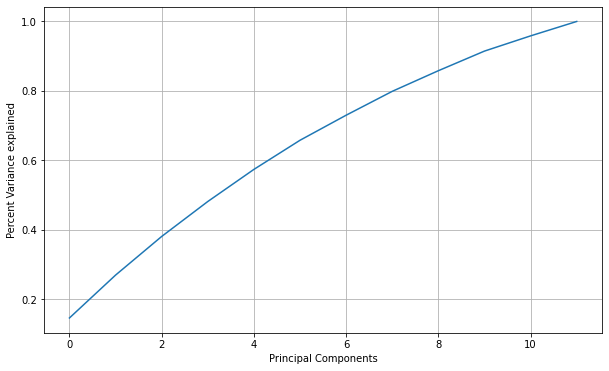

In [28]:
### Calculate PCA an plot percent variance explained

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
X_pca = pca.transform(X_train)
                      
plt.subplots(figsize=(10, 6))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.ylabel('Percent Variance explained')
plt.xlabel('Principal Components')
plt.grid(axis='both')
plt.show()

From the PCA it looks like ~10 principal components explain 95% of the variance.  During the modelling process I probably do not need more than 10 predictors in my model.  I will try NMF also to see if I can identify key columns in the NMF components.

Text(0.5, 1.0, 'Scatter plot of first 2 principal components\ncolored by negative(dark) or positive(light) WNV case')

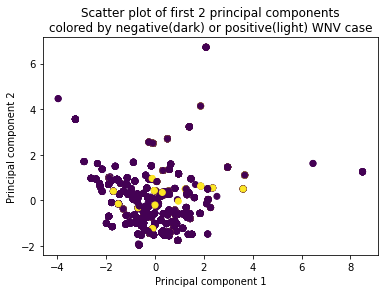

In [29]:
plt.scatter(X_pca[:,0],X_pca[:,1],c=y_train.to_numpy());
plt.ylabel('Principal component 2')
plt.xlabel('Principal component 1')
plt.title('Scatter plot of first 2 principal components\ncolored by negative(dark) or positive(light) WNV case')

The first two principal components don't distinguish between negative and positive WNV cases, but according to the cumulative variance curve above I wouldn't expect them to.  

Now I will apply a simple Logistic Regression model to predict the positive WNV cases. 

In [30]:
for dat in [X_train,X_test,y_train,y_test]:
    print(type(dat))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [31]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score,\
        plot_roc_curve, plot_precision_recall_curve, precision_recall_curve,\
        make_scorer, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression()
logreg_grid = GridSearchCV(logreg,param_grid={'class_weight':['balanced']},cv=5,
                          scoring = make_scorer(roc_auc_score))
logreg_grid.fit(X_train, y_train)


print('Training AUC:', roc_auc_score(y_train,logreg_grid.predict_proba(X_train)[:,1] )) 
print('Testint AUC:', roc_auc_score(y_test, logreg_grid.predict_proba(X_test)[:,1] )) 

Training AUC: 0.7953039129900832
Testint AUC: 0.7775494871126511


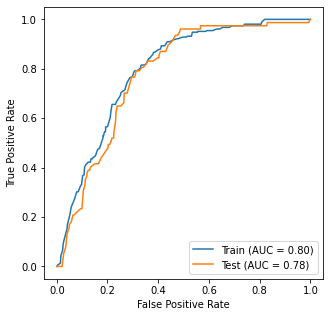

In [33]:
fig,ax = plt.subplots(figsize=(5,5))
plot_roc_curve(logreg_grid,X_train,y_train,ax=ax,name='Train')
plot_roc_curve(logreg_grid,X_test,y_test,ax=ax,name='Test')
plt.show()

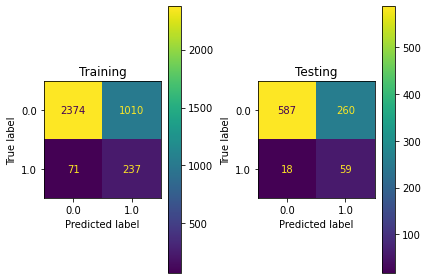

In [34]:
fig,ax = plt.subplots(1,2,tight_layout=True)

plot_confusion_matrix(logreg_grid,X_train,y_train,values_format='.4g',ax=ax[0])
plot_confusion_matrix(logreg_grid,X_test,y_test,values_format='.4g',ax=ax[1])

ax[0].set_title('Training')
ax[1].set_title('Testing')

plt.show()

In [35]:
### Training data Precision and recall
print('Training Metrics')
print('Precision: {:.3f}'.format(237/(237+1010)))
print('Recall:    {:.3f}'.format(237/(237+71)))
print()
print('Testing Metrics')
print('Precision: {:.3f}'.format(59/(59+260)))
print('Recall:    {:.3f}'.format(59/(59+18)))

Training Metrics
Precision: 0.190
Recall:    0.769

Testing Metrics
Precision: 0.185
Recall:    0.766


That looks ok.  Judging by the ROC curves the model is not overfit and it has decent predictive power.  The model recall is pretty good, which is important given the context of this project.  In the next notebook I will try to improve upon this model with more complex modelling techniques.

# Summary

In this notebook, first I imported the cleaned and merged data set.  Next I dropped non-numeric and other extraneous columns that could not be used for prediction of the test set.  

I split the data, 80% into a training set and 20% into a test set.  Then I used a function to calculate the weight of evidence and information value of each predictor to the target.  I dropped predictors that had IV >0.8 or <0.01.  Next I checked for colinearity in the data set by iteratively calculating the variance inflation factor for each feature.  This process filtered the predictors down to 12 that will be used for modeling. Then I applied a standard scaler to the predictors and exported the X_train, X_test, y_train, & y_test sets out to csv files.  

I performed PCA on the data set, but because I have reduced the features so much much with the previously mentioned steps, there is not much value in it.  The first two principal components do not seperate out the positive cases from the negative.  

Finally I applied a logistic regression to the training data set.  I did not attempt any hyper parameter tuning and the result was pretty good.  I will attempt to improve upon this with more advanced ML techniques in the next notebook.